In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install rasterio lightning pytorch-msssim kornia==0.6.3 rio-cogeo

In [ ]:
import drive.MyDrive.SuperResolution12RV2.inference_pipline as ip

# Ben test
import sys
sys.path.append('/content/drive/MyDrive/SuperResolution12RV2')
# Ben test

import subprocess
from rasterio.merge import merge
import torch
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import os
import gc
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
torch.set_default_device(device=device)
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [ ]:
src = "./drive/MyDrive/SuperResolution12RV2/"
site = 0
files = [f"{src}Site_{site}_Image_{num}.tif" for num in range(8)]
model_path = "/content/drive/MyDrive/SuperResolution12RV2/src/model.ckpt"

# Start x, start y, end x, end y
partial = [0,0,208,208]
overlap = 13
chip_size = 26

In [ ]:
# model = ip.load_model(model_path, device)

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.10 to v2.5.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint drive/MyDrive/SuperResolution12RV2/src/model.ckpt`
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.


In [ ]:
# infer = ip.do_inference_from_path(files,
#                                   model_path,
#                                   partial=partial,
#                                   overlap=overlap,
#                                   chip_size=chip_size,
#                                   device=device,
#                                   exclude8=False)

Getting partial Tiff
Original shape: torch.Size([8, 12, 208, 208])
Chip Shape: torch.Size([8, 12, 26, 26])
Chip Count: 225


INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.10 to v2.5.1.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint drive/MyDrive/SuperResolution12RV2/src/model.ckpt`
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.


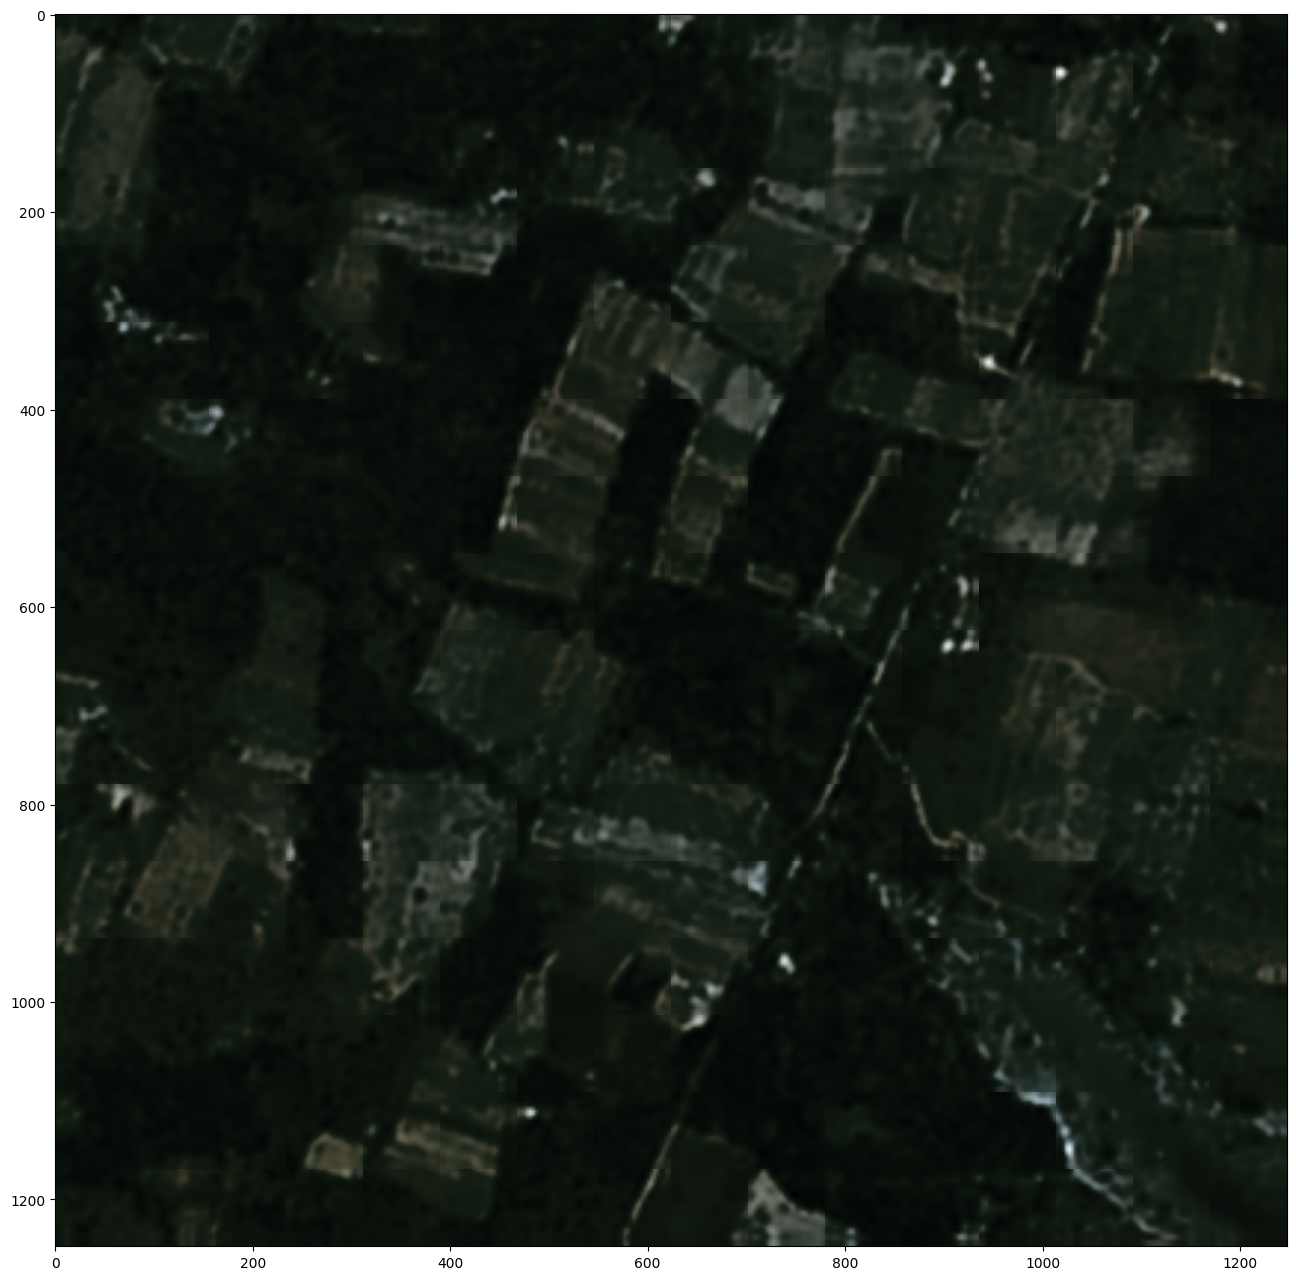

<Axes: >

In [ ]:
# plt.figure(figsize=(16,16))
# show(infer.cpu().detach().numpy(),adjust=True)

In [ ]:
# Test for a single tile

# base_metadata_path = files[0]
# export_name = "./drive/MyDrive/BenSuperResolutionInference/site0/x0_y0.tif"

# with rasterio.open(base_metadata_path) as r:
#     test = r.profile
# test["height"] = infer.shape[1]
# test["width"] = infer.shape[2]
# test["count"] = 3
# transform = rasterio.Affine(test["transform"][0] * (chip_size/156),
#                 test["transform"][1],
#                 test["transform"][2],
#                 test["transform"][3],
#                 test["transform"][4] * (chip_size/156),
#                 test["transform"][5])
# test["transform"] = transform

# with rasterio.open(export_name, 'w', **test) as w:
#     w.write(infer.cpu().round().to(torch.int32).detach().numpy())

In [ ]:
# Prepare metadata for batch export

base_metadata_path = files[0]
export_path = "/content/drive/MyDrive/BenSuperResolutionInference/site0_COG/"

with rasterio.open(base_metadata_path) as r:
    test = r.profile

width = test["width"]
height = test["height"]

test["height"] = 1248
test["width"] = 1248
test["count"] = 3
transform = rasterio.Affine(test["transform"][0] * (chip_size/156),
                test["transform"][1],
                test["transform"][2],
                test["transform"][3],
                test["transform"][4] * (chip_size/156),
                test["transform"][5])
test["transform"] = transform

In [ ]:
# # Alex's original working prediction export code, do not delete

# # del infer
# gc.collect()
# torch.cuda.empty_cache()
# for x in range(0,width-208,208):
#     for y in range(0,height-208,208):
#         partial = [x,y,x+208,y+208]
#         infer = ip.do_inference_from_path(files,
#                                           model_path,
#                                           partial=partial,
#                                           overlap=overlap,
#                                           chip_size=chip_size,
#                                           device=device,
#                                           verbose=False,
#                                           exclude8=False)
#         with rasterio.open(f"{export_path}x{x}_y{y}.tif", 'w', **test) as w:
#             w.write(infer.round().to(torch.int32).cpu().detach().numpy())
#         print(x,y)

#         del infer
#         gc.collect()
#         torch.cuda.empty_cache()

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.10 to v2.5.1.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint drive/MyDrive/SuperResolution12RV2/src/model.ckpt`
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.


In [ ]:
# Ben test prediction export as COG from the start (with Error Catching)
# del infer
gc.collect()
torch.cuda.empty_cache()
for x in range(0,width-208,208):
    for y in range(0,height-208,208):
        partial = [x,y,x+208,y+208]
        infer = ip.do_inference_from_path(files,
                                        model_path,
                                        partial=partial,
                                        overlap=overlap,
                                        chip_size=chip_size,
                                        device=device,
                                        verbose=False,
                                        exclude8=False)

        temp_path = f"{export_path}_x{x}_y{y}_temp.tif"
        with rasterio.open(temp_path, 'w', **test) as w:
            w.write(infer.round().to(torch.int32).cpu().detach().numpy())

        final_path = f"{export_path}x{x}_y{y}.tif"
        try:
            subprocess.run([
                "rio", "cogeo", "create",
                temp_path, final_path,
                "--co", "BIGTIFF=IF_SAFER",
                "--allow-intermediate-compression",  # Reduces temp file size
                "--no-in-memory",  # Force disk-based processing
                "--threads", "2",  # Limit parallel threads
                "--overview-level", "5"
            ], check=True, capture_output=True, text=True)
        except subprocess.CalledProcessError as e:
            print(f"Error creating COG for x={x}, y={y}:")
            print(f"Return code: {e.returncode}")
            print(f"Command: {e.cmd}")
            print(f"Stdout: {e.stdout}")
            print(f"Stderr: {e.stderr}")
            raise

        if os.path.exists(temp_path):
            os.remove(temp_path)

        print(x,y)

        del infer
        gc.collect()
        torch.cuda.empty_cache()

In [ ]:
def load_tif(path, device='cpu'):
    '''
    Load tiff from path into tensor
    '''
    with rasterio.open(path) as w:
        img = w.read()
    return torch.tensor(img).to(device)

In [ ]:
# Clear GPU ram for next steps
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Ben's working code, normalize and merge into 4 quadrants
gc.collect()
torch.cuda.empty_cache()

norm_to = files[0]
# image = load_tif(norm_to).to(torch.float32)
image = load_tif(norm_to, device=device).to(torch.float32) # fixed cpu + cuda

mu_g = image.mean(dim=(1,2), keepdim=True)[:3]
std_g = image.std(dim=(1,2), keepdim=True)[:3]

base_metadata_path = files[0]
export_path = "./drive/MyDrive/BenSuperResolutionInference/site0_COG/"

with rasterio.open(base_metadata_path) as r:
    test = r.profile

width = test["width"]
height = test["height"]

test["height"] = 1248
test["width"] = 1248
test["count"] = 3
transform = rasterio.Affine(test["transform"][0] * (chip_size/156),
                test["transform"][1],
                test["transform"][2],
                test["transform"][3],
                test["transform"][4] * (chip_size/156),
                test["transform"][5])
test["transform"] = transform

# Define quadrant parameters: (name, sec_x, sec_y)
quadrants = [
    ("group_top_left", False, False),
    ("group_top_right", True, False),
    ("group_bottom_left", False, True),
    ("group_bottom_right", True, True)
]

for quadrant_name, sec_x, sec_y in quadrants:
    gc.collect()
    torch.cuda.empty_cache()

    r_x = range(0, (width - width % 208) // 208 // 2 + sec_x)
    r_y = range(0, (height - height % 208) // 208 // 2 + sec_y)

    start_x = sec_x * (len(r_x) - 1) * 208
    start_y = sec_y * (len(r_y) - 1) * 208

    n_height = len(r_y) * 1248
    n_width = len(r_x) * 1248
    canvas = torch.zeros((3, n_height, n_width))

    for x in range(len(r_x)):
        for y in range(len(r_y)):
            tile_path = f"{export_path}x{x * 208 + start_x}_y{y * 208 + start_y}.tif"
            if not os.path.exists(tile_path):
                print(f"Missing tile: {tile_path}")
                continue

            infer = load_tif(tile_path, device=device).to(torch.float32)
            infer = (infer - infer.mean(dim=(1,2), keepdim=True)) / infer.std(dim=(1,2), keepdim=True) * std_g + mu_g
            canvas[:, y*1248:(y+1)*1248, x*1248:(x+1)*1248] += infer
            del infer
            gc.collect()
            torch.cuda.empty_cache()

    transform = rasterio.Affine(
        test["transform"][0],
        test["transform"][1],
        test["transform"][2] + test["transform"][0] * start_x * 6,
        test["transform"][3],
        test["transform"][4],
        test["transform"][5] + test["transform"][4] * start_y * 6
    )

    quadrant_profile = test.copy()
    quadrant_profile.update({
        "transform": transform,
        "height": n_height,
        "width": n_width
    })

    canvas = canvas.to(torch.int32).cpu()
    with rasterio.open(f"{export_path}{quadrant_name}_normTest.tif", 'w', **quadrant_profile) as w:
        w.write(canvas.detach().numpy())

In [ ]:
# Clear GPU ram for next steps
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Merge the 4 quadrants into one final Cloud Optimized Geotiff
def merge_rasters(files, output_path):
    """
    Merge multiple raster files into one and save the result as a COG.

    Parameters:
    - input_files (list of str): Paths to input raster files.
    - output_path (str): Path where the merged raster will be saved.
    """
    src_files_to_mosaic = []

    for file in files:
        with rasterio.open(file) as src:
            src_files_to_mosaic.append(src)

    src_files_to_mosaic = [rasterio.open(file) for file in files]

    mosaic, transform = merge(src_files_to_mosaic)

    output_meta = src_files_to_mosaic[0].meta.copy()
    output_meta.update({
        "driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": transform,
        "count": mosaic.shape[0]
    })

    # Temporary tif file to create a COG
    temp_output = output_path.replace(".tif", "_temp.tif")

    with rasterio.open(temp_output, "w", **output_meta) as dest:
        dest.write(mosaic)

    for src in src_files_to_mosaic:
        src.close()

    print(f"Temporary raster saved to: {temp_output}")

    subprocess.run(["rio", "cogeo", "create", temp_output, output_path], check=True)
    print(f"Final Cloud Optimized GeoTIFF saved to: {output_path}")

    os.remove(temp_output)

In [ ]:
files = [f"{export_path}{q[0]}_normTest.tif" for q in quadrants]

output = f"{export_path}merged_raster_COG.tif"
merge_rasters(files, output)

Temporary raster saved to: ./drive/MyDrive/BenSuperResolutionInference/site0_COG/merged_raster_COG_temp.tif
Final Cloud Optimized GeoTIFF saved to: ./drive/MyDrive/BenSuperResolutionInference/site0_COG/merged_raster_COG.tif


In [ ]:
# files = ["/content/drive/MyDrive/SuperResolution12RV2/SuperResolutionInference/site0/bottom_left_normTest.tif",
#          "/content/drive/MyDrive/SuperResolution12RV2/SuperResolutionInference/site0/bottom_right_normTest.tif",
#          "/content/drive/MyDrive/SuperResolution12RV2/SuperResolutionInference/site0/top_left_normTest.tif",
#          "/content/drive/MyDrive/SuperResolution12RV2/SuperResolutionInference/site0/top_right_normTest.tif"]

# output = "/content/drive/MyDrive/SuperResolution12RV2/SuperResolutionInference/site0/merged_raster_COG.tif"
# merge_rasters(files, output)

In [ ]:
# Alex's original working code: normalize individually, specify each Quad

# """         x     y
# Top-Left	False	False
# Top-Right	True	False
# Bottom-Left	False	True
# Bottom-Right	True	True
# """


# norm_to = files[0]
# # image = load_tif(norm_to).to(torch.float32)
# image = load_tif(norm_to, device=device).to(torch.float32) # Load directly to the device

# mu_g = image.mean(dim=(1,2), keepdim=True)[:3]
# std_g = image.std(dim=(1,2), keepdim=True)[:3]

# base_metadata_path = files[0]
# export_path = "./drive/MyDrive/BenSuperResolutionInference/site0/"

# with rasterio.open(base_metadata_path) as r:
#     test = r.profile

# width = test["width"]
# height = test["height"]

# test["height"] = 1248
# test["width"] = 1248
# test["count"] = 3
# transform = rasterio.Affine(test["transform"][0] * (chip_size/156),
#                 test["transform"][1],
#                 test["transform"][2],
#                 test["transform"][3],
#                 test["transform"][4] * (chip_size/156),
#                 test["transform"][5])
# test["transform"] = transform

# sec_x = True
# sec_y = False

# gc.collect()
# torch.cuda.empty_cache()

# r_x = range(0, (width - width %208) // 208 // 2 + sec_x)
# r_y = range(0, (height - height %208) // 208 // 2 + sec_y)

# n_height = len(r_y) * 1248
# n_width = len(r_x) * 1248
# display(n_height,n_width)

# start_x = sec_x * (len(r_x) - 1) * 208
# start_y = sec_y * (len(r_y) - 1) * 208

# canvas = torch.zeros((3,n_height, n_width))

# test["height"] = n_height
# test["width"] = n_width

# #canvas = torch.zeros((3,n_height, n_width)).to('cpu')
# for x in range(0, (width - width %208) // 208 // 2 + sec_x):
#     for y in range(0, (height - height %208) // 208 // 2 + sec_y):
#         infer = load_tif(f"{export_path}x{x * 208 + start_x}_y{y * 208 + start_y}.tif", device=device).to(torch.float32)
#         infer = (infer - infer.mean(dim=(1,2), keepdim=True)) / infer.std(dim=(1,2), keepdim=True) * std_g + mu_g
#         canvas[:,y*1248:y*1248+1248,x*1248:x*1248+1248] += infer

#         del infer
#         gc.collect()
#         torch.cuda.empty_cache()

# canvas = canvas.to(torch.int32).cpu()

# transform = rasterio.Affine(test["transform"][0],
#                 test["transform"][1],
#                 test["transform"][2] +
#                             test["transform"][0] *
#                             start_x * 6,
#                 test["transform"][3],
#                 test["transform"][4],
#                 test["transform"][5] +
#                             test["transform"][4] *
#                             start_y * 6)
# test["transform"] = transform

# with rasterio.open(f"{export_path}top_right_normTest.tif", 'w', **test) as w:
#     w.write(canvas.detach().numpy())

13728

19968

In [ ]:
#len(range((width - width %208) // 208 // 2,(width - width %208) // 208))


In [ ]:
# # Alex's original working code, only one region

# # Handle the edges of the image chips
# sec_x = True
# sec_y = True

# # Clear memory
# gc.collect()
# torch.cuda.empty_cache()

# # Calc range of tiles
# r_x = range(0, (width - width %208) // 208 // 2 + sec_x)
# r_y = range(0, (height - height %208) // 208 // 2 + sec_y)

# # Calc raster dimensions
# n_height = len(r_y) * 1248
# n_width = len(r_x) * 1248
# display(n_height,n_width)

# start_x = sec_x * (len(r_x) - 1) * 208
# start_y = sec_y * (len(r_y) - 1) * 208

# canvas = torch.zeros((3,n_height, n_width))

# test["height"] = n_height
# test["width"] = n_width
# #canvas = torch.zeros((3,n_height, n_width)).to('cpu')
# for x in range(0, (width - width %208) // 208 // 2 + sec_x):
#     for y in range(0, (height - height %208) // 208 // 2 + sec_y):
#         infer = load_tif(f"{export_path}x{x * 208 + start_x}_y{y * 208 + start_y}.tif", device=device)
#         canvas[:,y*1248:y*1248+1248,x*1248:x*1248+1248] += infer

#         del infer
#         gc.collect()
#         torch.cuda.empty_cache()
# canvas = canvas.to(torch.int16).cpu()
# with rasterio.open(f"{export_path}bottom_right.tif", 'w', **test) as w:
#     w.write(canvas.detach().numpy())

14976

19968

In [ ]:
# Check output resolution (1.5 m)

# with rasterio.open("/content/drive/MyDrive/BenSuperResolutionInference/site0/x1872_y4160.tif") as src:
#     # Get pixel size in meters (for projected CRS like UTM)
#     x_res = src.transform.a  # X resolution (e.g., 1.5)
#     y_res = abs(src.transform.e)  # Y resolution (e.g., 1.5)
#     crs_units = src.crs.linear_units  # Confirm units (should be "metre")

# print(f"Resolution: {x_res}m (X), {y_res}m (Y)")

# #Resolution: 1.4971921401992024e-05m (X), 1.4971921401992024e-05m (Y)


Resolution: 1.4971921401992024e-05m (X), 1.4971921401992024e-05m (Y)
